In [1]:
import os
import pickle
import time
import numpy as np
import json
import matplotlib.pyplot as plt

# utils imports
from power_planner.data_reader import DataReader
from power_planner import graphs
from power_planner.plotting import plot_path_costs, plot_pipeline_paths, plot_path, plot_k_sp
from power_planner.utils.utils import get_distance_surface, time_test_csv
from config import Config

In [4]:
PATH_FILES = "../data"

# DEFINE CONFIGURATION
ID = "w_ksp_5"  # str(round(time.time() / 60))[-5:]

OUT_PATH = "outputs/path_" + ID
SCALE_PARAM = 5  # args.scale
PIPELINE = [(1, 0)]  # [(0.9, 40), (0, 0)]

GRAPH_TYPE = graphs.WeightedGraph
# LineGraph, WeightedGraph, RandomWeightedGraph, RandomLineGraph, PowerBF
# TwoPowerBF, WeightedKSP
print("graph type:", GRAPH_TYPE)
# summarize: mean/max/min, remove: all/surrounding, sample: simple/watershed
NOTES = "None"  # "mean-all-simple"

IOPATH = os.path.join(PATH_FILES, "data_dump_" + str(SCALE_PARAM) + ".dat")

cfg = Config(SCALE_PARAM)

graph type: <class 'power_planner.graphs.weighted_graph.WeightedGraph'>
defined pylon distances in raster: 3.0 5.0


In [5]:
# READ DATA
with open(IOPATH, "rb") as infile:
    data = pickle.load(infile)
    (instance, instance_corr, start_inds, dest_inds) = data.data

### Notes:

* need range as broad as maxDist
* more than two parts --> multiple sources problem --> here concentrated on two for now

In [6]:
# not used right now
N_PARTS = 2

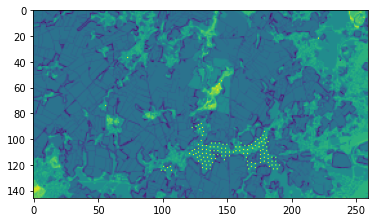

In [7]:
plt.imshow(instance[2])

In [8]:
def split_arr(arr, half_pixels, margin, axis=0):
    if axis==0:
        return arr[:half_pixels+int(margin), :], arr[half_pixels-int(margin):, :]
    elif axis==1:
        return arr[:, :half_pixels+int(margin)], arr[:, half_pixels-int(margin):]
    else:
        raise ValueError("wrong split axis, must be 0 or 1")

## Actual start of script

### Avoid axis pain by swapaxes

In [9]:
split_axis = np.argmax(np.absolute(start_inds-dest_inds))
if split_axis==1:
    instance = np.swapaxes(instance, 2,1)
    instance_corr = np.swapaxes(instance_corr, 1, 0)
    start_inds = np.flip(start_inds)
    dest_inds = np.flip(dest_inds)

### Construct patches

In [10]:
def construct_patches(instance, instance_corr, pix_per_part, margin, padding):
    two_insts = [(instance[:, :pix_per_part+margin+padding]).copy(), (instance[:, pix_per_part-margin-padding:]).copy()]
    two_corrs = [(instance_corr[:pix_per_part+margin]).copy(), (instance_corr[pix_per_part-margin:]).copy()]
    pad_zeros = np.zeros((padding, instance_corr.shape[1]))
    two_corrs[0] = np.concatenate((two_corrs[0], pad_zeros), axis=0)
    two_corrs[1] = np.concatenate((pad_zeros, two_corrs[1]), axis=0)
    return two_insts, two_corrs

In [11]:
pix_per_part = int(instance.shape[1]/2)
margin = int(cfg.PYLON_DIST_MAX)
padding = 20    
two_insts, two_corrs = construct_patches(instance, instance_corr, pix_per_part, margin, padding)
# two_insts = [(instance[:, :pix_per_part+margin]).copy(), (instance[:, pix_per_part-margin:]).copy()]
# two_corrs = [(instance_corr[:pix_per_part+margin]).copy(), (instance_corr[pix_per_part-margin:]).copy()]

In [12]:
print("check shapes:", two_insts[0].shape, instance.shape, instance_corr.shape, two_corrs[0].shape, two_corrs[1].shape)


check shapes: (4, 155, 146) (4, 260, 146) (260, 146) (155, 146) (155, 146)


### Set start and dest

In [13]:
deleted_part = pix_per_part-margin-padding

# if start is in first part and dest in second
if start_inds[0] < dest_inds[0]:
    start_points = [start_inds, dest_inds-[deleted_part, 0]]
# if dest is in first part and start is in second one
else:
    start_points = [dest_inds, start_inds-[deleted_part, 0]]

two_graphs = [None, None]

print(deleted_part, start_points)

105 [array([ 22, 108]), array([133,  39])]


In [14]:
# make sure we got the correct point
assert two_insts[1][2, start_points[1][0],start_points[1][1]] == instance[2, dest_inds[0], dest_inds[1]]

### Construct both graphs

In [15]:
# do all steps for both seperately
vec = start_points[1]-start_points[0]  # start to dest vector

for i in range(2):
    graph = GRAPH_TYPE(
        two_insts[i], two_corrs[i], graphtool=cfg.GTNX, verbose=cfg.VERBOSE
    )

    graph.set_edge_costs(
        data.layer_classes, data.class_weights, angle_weight=cfg.ANGLE_WEIGHT
    )
    
    # for the second graph, the shifts must be exactly the same as for the first one, just flipped
    if i==1:
        graph.angle_norm_factor = cfg.MAX_ANGLE_LG
        graph.shifts = np.asarray(two_graphs[0].shifts) * (-1)
        graph.shift_tuples = graph.shifts
    else:
        graph.set_shift(
            cfg.PYLON_DIST_MIN,
            cfg.PYLON_DIST_MAX,
            vec,
            cfg.MAX_ANGLE,
            max_angle_lg=cfg.MAX_ANGLE_LG
        )
    
    # add vertices
    graph.add_nodes()
    corridor = np.ones(two_corrs[i].shape) * 0.5 
    graph.set_corridor(
        corridor, start_points[i], start_points[i], factor_or_n_edges=1 # start_points[(i+1)%2],
    )
    graph.add_edges()
    graph.sum_costs()
    
    # save the current graph
    two_graphs[i] = graph

initialized weighted graph pos2node
['cultural', 'human', 'planning', 'technical'] [0.28571429 0.35714286 0.14285714 0.21428571]
Added nodes: 22630 in time: 0.015755176544189453
n_neighbors: 28
Done adding edges: 272600
DONE adding 272600 edges: 0.4510936737060547
initialized weighted graph pos2node
['cultural', 'human', 'planning', 'technical'] [0.28571429 0.35714286 0.14285714 0.21428571]
Added nodes: 22630 in time: 0.007390022277832031
n_neighbors: 28
Done adding edges: 221828
DONE adding 221828 edges: 0.32846713066101074


# For normal graph

In [16]:
def get_sp_from_preds(pred_map, curr_vertex, start_vertex):
    path = [int(curr_vertex)]
    counter = 0
    while curr_vertex != start_vertex:
        curr_vertex = pred_map[curr_vertex]
        path.append(curr_vertex)
        if counter > 100:
            print(path)
            raise RuntimeWarning("while loop for sp not terminating")
        counter += 1
    return path

In [17]:
from graph_tool.all import shortest_distance

In [18]:
critical_zones = [None, None]
critical_zones[0] = two_graphs[0].pos2node[pix_per_part:-padding, :]
critical_zones[1] = two_graphs[1].pos2node[padding:padding+margin, :]

In [19]:
assert len(critical_zones[0])==margin
summed = np.zeros(critical_zones[0].shape)
pred_maps = []
for i in range(2):
    start_node_ind = two_graphs[i].pos2node[start_points[i][0], start_points[i][1]]
    dist_map, pred_map = shortest_distance(
                two_graphs[i].graph,
                start_node_ind,
                weights=two_graphs[i].weight,
                negative_weights=True,
                pred_map=True
            )
    pred_maps.append(pred_map)
    for j in range(margin):
        for k in range(summed.shape[1]):
            node = critical_zones[i][j,k]
            if node>=0:
                summed[j,k] += dist_map[node]
            else:
                summed[j,k] += np.inf

In [20]:
inds0, inds1 = np.where(summed==np.min(summed))

In [21]:
assert len(inds0)==1

### Construct both paths

In [38]:
best_nodes = [None, None]
best_nodes[0] = two_graphs[0].pos2node[inds0[0]+pix_per_part, inds1[0]]
best_nodes[1] = two_graphs[1].pos2node[inds0[0]+padding+margin, inds1[0]]

concat_path = []
for i in range(2):
    start_node_ind = two_graphs[i].pos2node[start_points[i][0], start_points[i][1]]
    vertices_path = get_sp_from_preds(pred_maps[i], best_nodes[i], start_node_ind)
    path = np.array([(ind // two_graphs[i].y_len, ind % two_graphs[i].y_len) for ind in vertices_path])
    ind = best_nodes[i]
    print(ind // two_graphs[i].y_len, ind % two_graphs[i].y_len)
    if i==0:
        # -padding is not required because we only pad at the opposite side
        path = np.flip(path, axis=0)
    else:
        path[:,0] = path[:,0]+deleted_part
        path = path[1:]
    concat_path.extend(path.tolist())

133 83
28 83


In [39]:
concat_path

[[22, 108],
 [26, 111],
 [31, 111],
 [35, 108],
 [39, 105],
 [43, 102],
 [47, 99],
 [51, 96],
 [55, 98],
 [59, 99],
 [64, 99],
 [69, 99],
 [74, 99],
 [79, 99],
 [83, 96],
 [87, 93],
 [91, 90],
 [95, 87],
 [100, 87],
 [105, 87],
 [110, 87],
 [114, 86],
 [119, 86],
 [124, 86],
 [128, 83],
 [133, 83],
 [137, 80],
 [142, 80],
 [147, 80],
 [152, 80],
 [157, 80],
 [161, 78],
 [166, 78],
 [170, 75],
 [174, 72],
 [178, 69],
 [183, 69],
 [188, 69],
 [192, 66],
 [196, 63],
 [200, 60],
 [205, 60],
 [209, 57],
 [214, 57],
 [218, 54],
 [222, 51],
 [226, 48],
 [230, 45],
 [234, 42],
 [238, 39]]

# For implicit LG

### Show distance surfaces

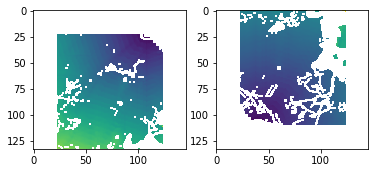

In [37]:
plt.subplot(1,2,1)
plt.imshow(np.min(two_graphs[0].dists, axis=0))
plt.subplot(1,2,2)
plt.imshow(np.min(two_graphs[1].dists, axis=0))

### Get overlapping part, the nodes that exist in both parts

In [22]:
critical_zone0 = two_graphs[0].dists[:, pix_per_part:, :]
critical_zone1 = two_graphs[1].dists[:, :int(margin), :]
inst_zone = two_graphs[0].instance[pix_per_part:, :]

In [23]:
critical_zone0.shape, critical_zone1.shape

((28, 3, 146), (28, 3, 146))

### Helper functions to get sp

In [42]:
def _flat_ind_to_inds(flat_ind, arr_shape):
    """
    Transforms an index of a flattened 3D array to its original coords
    """
    _, len2, len3 = arr_shape
    x1 = flat_ind // (len2 * len3)
    x2 = (flat_ind % (len2 * len3)) // len3
    x3 = (flat_ind % (len2 * len3)) % len3
    return (x1, x2, x3)


def get_sp_start_shift(
    dists, dists_argmin, start_inds, dest_inds, shifts, min_shift
):
    if not np.any(dists[:, dest_inds[0], dest_inds[1]] < np.inf):
        raise RuntimeWarning("empty path")
    curr_point = np.asarray(dest_inds)
    my_path = [dest_inds]
    # min_shift = np.argmin(dists[:, dest_inds[0], dest_inds[1]])
    while np.any(curr_point - start_inds):
        # print(curr_point)
        new_point = curr_point - shifts[int(min_shift)]
        min_shift = dists_argmin[int(min_shift), curr_point[0],
                                 curr_point[1]]
        my_path.append(new_point)
        curr_point = new_point
    return np.asarray(my_path)

### Find best merge node

In [25]:
# iterate over all edges
summed_dists = (
    critical_zone0 + critical_zone1 - inst_zone
)
summed_dists[np.isnan(summed_dists)] = np.inf

# get actual inds in smaller window
best_path_ind = np.argmin(summed_dists.flatten())

# get actual inds in smaller window
best_shift, x, y = _flat_ind_to_inds(
    best_path_ind, summed_dists.shape
)

print(best_path_ind, best_shift, x,y)

9571 21 2 81


<ipython-input-25-73abeab8eb0f>:3: RuntimeWarning: invalid value encountered in subtract
  critical_zone0 + critical_zone1 - inst_zone


### Construct both paths from merge node

In [49]:
path_ab = get_sp_start_shift(two_graphs[0].dists, two_graphs[0].dists_argmin, start_points[0], 
                          [x+pix_per_part-1, y], two_graphs[0].shifts, best_shift)
path_cb = get_sp_start_shift(two_graphs[1].dists, two_graphs[1].dists_argmin, start_points[1],
                          [x,y], two_graphs[1].shifts, best_shift)

In [44]:
path_cb = np.array(path_cb)[1:]
path_cb[:,0] = path_cb[:,0]+deleted_part

together = np.concatenate(
            (np.flip(np.array(path_ac), axis=0), path_cb),
            axis=0
        )

In [36]:
together

array([[ 22, 108],
       [ 26, 111],
       [ 31, 111],
       [ 35, 108],
       [ 39, 105],
       [ 43, 102],
       [ 47,  99],
       [ 51,  96],
       [ 55,  98],
       [ 59,  99],
       [ 64,  99],
       [ 69,  99],
       [ 74,  99],
       [ 79,  99],
       [ 83,  96],
       [ 87,  93],
       [ 91,  90],
       [ 95,  87],
       [100,  87],
       [105,  87],
       [110,  87],
       [114,  86],
       [119,  86],
       [124,  86],
       [128,  83],
       [133,  83],
       [133,  83],
       [137,  80],
       [142,  80],
       [147,  80],
       [152,  80],
       [157,  80],
       [161,  78],
       [166,  78],
       [170,  75],
       [174,  72],
       [178,  69],
       [183,  69],
       [188,  69],
       [192,  66],
       [196,  63],
       [200,  60],
       [205,  60],
       [209,  57],
       [214,  57],
       [218,  54],
       [222,  51],
       [226,  48],
       [230,  45],
       [234,  42],
       [238,  39]])

## Check whether it is the correct path

### Run for full instance

In [40]:
graph = GRAPH_TYPE(
    instance, instance_corr, graphtool=cfg.GTNX, verbose=cfg.VERBOSE
)

graph.set_edge_costs(
    data.layer_classes, data.class_weights, angle_weight=cfg.ANGLE_WEIGHT
)

graph.set_shift(
    cfg.PYLON_DIST_MIN,
    cfg.PYLON_DIST_MAX,
    dest_inds-start_inds,
    cfg.MAX_ANGLE,
    max_angle_lg=cfg.MAX_ANGLE_LG
)

# add vertices
graph.add_nodes()

corridor = np.ones(instance_corr.shape) * 0.5
graph.set_corridor(
    corridor, start_inds, dest_inds, factor_or_n_edges=1
)
print("1) set cost rest")
graph.add_edges()
graph.sum_costs()
start_v, target_v = graph.add_start_and_dest(start_inds, dest_inds)
path, _,_ = graph.get_shortest_path(start_v, target_v)

initialized weighted graph pos2node
['cultural', 'human', 'planning', 'technical'] [0.28571429 0.35714286 0.14285714 0.21428571]
Added nodes: 37960 in time: 0.015825986862182617
1) set cost rest
n_neighbors: 28
Done adding edges: 483010
DONE adding 483010 edges: 0.6908049583435059


### Compare outputs

In [41]:
for i in range(len(path)):
    print(path[i], concat_path[i]) # together[i])#

(22, 108) [22, 108]
(26, 111) [26, 111]
(31, 111) [31, 111]
(35, 108) [35, 108]
(39, 105) [39, 105]
(43, 102) [43, 102]
(47, 99) [47, 99]
(51, 96) [51, 96]
(55, 98) [55, 98]
(59, 99) [59, 99]
(64, 99) [64, 99]
(69, 99) [69, 99]
(74, 99) [74, 99]
(79, 99) [79, 99]
(83, 96) [83, 96]
(87, 93) [87, 93]
(91, 90) [91, 90]
(95, 87) [95, 87]
(100, 87) [100, 87]
(105, 87) [105, 87]
(110, 87) [110, 87]
(114, 86) [114, 86]
(119, 86) [119, 86]
(124, 86) [124, 86]
(128, 83) [128, 83]
(133, 83) [133, 83]
(137, 80) [137, 80]
(142, 80) [142, 80]
(147, 80) [147, 80]
(152, 80) [152, 80]
(157, 80) [157, 80]
(161, 78) [161, 78]
(166, 78) [166, 78]
(170, 75) [170, 75]
(174, 72) [174, 72]
(178, 69) [178, 69]
(183, 69) [183, 69]
(188, 69) [188, 69]
(192, 66) [192, 66]
(196, 63) [196, 63]
(200, 60) [200, 60]
(205, 60) [205, 60]
(209, 57) [209, 57]
(214, 57) [214, 57]
(218, 54) [218, 54]
(222, 51) [222, 51]
(226, 48) [226, 48]
(230, 45) [230, 45]
(234, 42) [234, 42]
(238, 39) [238, 39]


In [50]:
path_cb

array([[  2,  81],
       [  6,  79],
       [ 11,  79],
       [ 16,  79],
       [ 21,  79],
       [ 26,  79],
       [ 31,  79],
       [ 36,  79],
       [ 41,  79],
       [ 46,  79],
       [ 51,  79],
       [ 55,  76],
       [ 59,  73],
       [ 63,  70],
       [ 67,  67],
       [ 71,  65],
       [ 75,  63],
       [ 79,  61],
       [ 83,  59],
       [ 87,  57],
       [ 91,  54],
       [ 95,  51],
       [ 99,  48],
       [103,  45],
       [107,  42],
       [111,  39]])

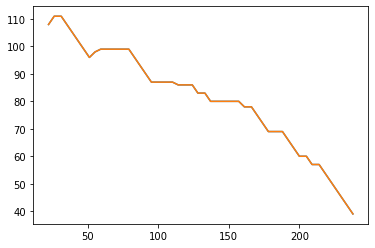

In [26]:
together = np.array(concat_path)
path = np.array(path)
plt.plot(path[:,0], path[:,1])
plt.plot(together[:,0], together[:,1])